Lambda School Data Science

Build Week Notebook

In [1]:
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

In [2]:
# Importing tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split 
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
%matplotlib inline
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot

In [3]:
# Reading the data
df = pd.read_csv('character-predictions.csv')

In [4]:
df2 = df.copy()
df2.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

In [6]:
# Looking at nans columns
nans = df.isnull().sum()
nans[nans > 0]

title            1008
culture          1269
dateOfBirth      1513
DateoFdeath      1502
mother           1925
father           1920
heir             1923
house             427
spouse           1670
isAliveMother    1925
isAliveFather    1920
isAliveHeir      1923
isAliveSpouse    1670
age              1513
dtype: int64

In [7]:
# Age is a very important feature to determine survival
print(df['age'].mean())

# identifying age rows with negative values
print("\n", df['name'][df['age'] < 0])
print(df['age'][df['age'] < 0])

# replacing Doreah with random average age'25' & Rheago '0' never was born
df.loc[1684, 'age'] = 25.0
df.loc[1868, 'age'] = 0.0

# age mean value
print('\n', df['age'].mean())

-1293.5635103926097

 1684    Doreah
1868    Rhaego
Name: name, dtype: object
1684   -277980.0
1868   -298001.0
Name: age, dtype: float64

 36.70438799076212


In [8]:
# filling age's NaNs with the mean value of the column
df['age'].fillna(df['age'].mean(), inplace=True)

# Culture is also an importan feat for survival
# will fill NaNs with an emmpty str
df['culture'].fillna('', inplace=True)

# Filling the rest of the dataset NaNs with -1
# since we dont know the values
df.fillna(value= -1, inplace=True)

In [9]:
# choosing my target
target = df['isAlive']

#dropping target to avoid leakage & unusable columns
df = df.drop(['isAlive', 'S.No', 'alive', 'name', 'pred', 'plod', 'dateOfBirth', 
               'DateoFdeath'], axis=1)

# converting uppercase str to lower
df['title'] = df['title'].str.lower()
df['culture'] = df['culture'].str.lower()
df['heir'] = df['heir'].str.lower()
df['house'] = df['house'].str.lower()
df['spouse'] = df['spouse'].str.lower()

In [10]:
df.head()

,actual,title,male,culture,mother,father,heir,house,spouse,book1,...,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity
0,0,NaN,1,,Rhaenyra Targaryen,Daemon Targaryen,aegon iv targaryen,NaN,NaN,0,...,0.0,0.0,-1.0,0,0,36.704388,11,1,1,0.605351
1,1,lord of the crossing,1,rivermen,-1,-1,NaN,house frey,perra royce,1,...,-1.0,-1.0,1.0,1,1,97.000000,1,1,1,0.896321
2,1,ser,1,,-1,-1,NaN,house swyft,NaN,0,...,-1.0,-1.0,-1.0,0,1,36.704388,0,0,0,0.267559
3,0,queen,0,,-1,-1,NaN,house arryn,viserys i targaryen,0,...,-1.0,-1.0,0.0,1,1,23.000000,0,0,0,0.183946
4,1,greenstone,0,dornish,-1,-1,NaN,house santagar,eldon estermont,0,...,-1.0,-1.0,1.0,1,1,29.000000,0,0,0,0.043478


In [11]:
 df.culture.nunique()

60

In [12]:
# Arranging repeated cultures into one 
set(df['culture'])

{'',
 'andal',
 'andals',
 'asshai',
 "asshai'i",
 'astapor',
 'astapori',
 'braavos',
 'braavosi',
 'crannogmen',
 'dorne',
 'dornish',
 'dornishmen',
 'dothraki',
 'first men',
 'free folk',
 'ghiscari',
 'ghiscaricari',
 'ibbenese',
 'ironborn',
 'ironmen',
 'lhazareen',
 'lhazarene',
 'lysene',
 'lyseni',
 'meereen',
 'meereenese',
 'myrish',
 'naathi',
 'northern mountain clans',
 'northmen',
 'norvos',
 'norvoshi',
 'pentoshi',
 'qarth',
 'qartheen',
 'qohor',
 'reach',
 'reachmen',
 'rhoynar',
 'riverlands',
 'rivermen',
 'sistermen',
 'stormlander',
 'stormlands',
 'summer islander',
 'summer islands',
 'summer isles',
 'the reach',
 'tyroshi',
 'vale',
 'vale mountain clans',
 'valemen',
 'valyrian',
 'westerlands',
 'westerman',
 'westermen',
 'westeros',
 'wildling',
 'wildlings'}

In [13]:
# too  many names for the same culture
# grouping them 
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
    'Ironborn': ['ironborn', 'ironmen'],
    'Mereen': ['meereen', 'meereenese'],
    'RiverLands': ['riverlands', 'rivermen'],
    'Vale': ['vale', 'valemen', 'vale mountain clans']
}

def names_fix(name):
    for k, v in cult.items():
        if name.lower() in v:
            return k

# saving a copy of dataset
df1 = df.copy(deep=True)

In [14]:
# separating labels from features
x = df.iloc[:,1:].values
y = df.iloc[:, 0].values

In [15]:
# Split data keeping 80% for training and the rest for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=42)

# Baseline accurracy 
y_base = pd.Series(y)

In [16]:
print('Baseline accuracy:', y_base.value_counts(normalize=True).max())

Baseline accuracy: 0.7456320657759506


In [17]:
# Arranging linear regression
lr = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(), 
    LinearRegression()
)
# fitting the model
lr.fit(x, y)
print('Linear Regression R^2:', lr.score(x, y))

Linear Regression R^2: 0.17621623602742587


In [18]:
# logistic reg pipeline trail
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    LogisticRegression(solver='liblinear'),
)

# fitting the models 
pipeline.fit(x_train, y_train)

# getting the probability of assigning each sample to class
lr_prob = pipeline.predict_proba(x_test)

# gettting the actual pred
lr_preds = np.argmax(lr_prob, axis=1)

In [19]:
# randomFoCla pipeline trail
pipeline1 = make_pipeline(
    ce.OneHotEncoder(),
    RandomForestClassifier(n_estimators=400, random_state=42)
)
# fitting the models 
pipeline1.fit(x_train, y_train)

# getting the probability of assigning each sample to class
rf_prob = pipeline1.predict_proba(x_test)

# gettting the actual pred
rf_preds = np.argmax(rf_prob, axis=1)

In [20]:
# decisiontreecla pipeline tral
pipeline2 = make_pipeline(
    ce.OneHotEncoder(),
    DecisionTreeClassifier(random_state=42)
)
# fitting the models 
pipeline2.fit(x_train, y_train)

# getting the probability of assigning each sample to class
dt_prob = pipeline2.predict_proba(x_test)

# gettting the actual pred
dt_preds = np.argmax(dt_prob, axis=1)

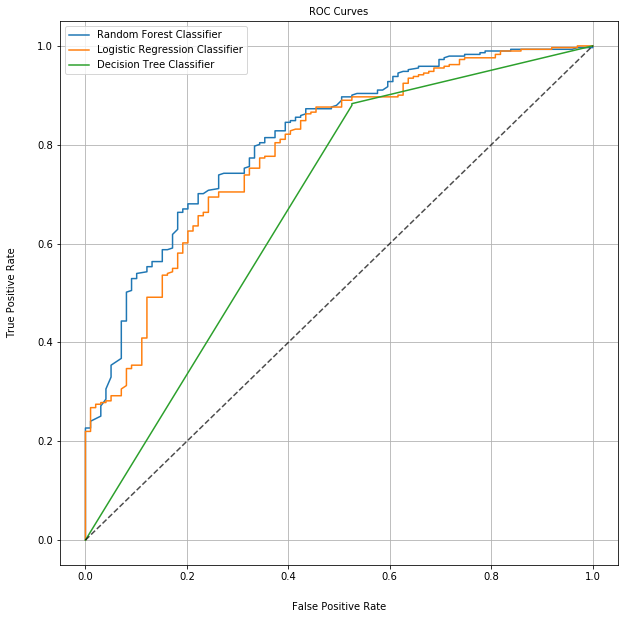

In [21]:
# Plotting ROC Curve to identify classifier performance 
fig = plt.figure(figsize=(10, 10))
plt.plot(*roc_curve(y_test, rf_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, lr_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, dt_prob[:, 1])[:2])
plt.legend(["Random Forest Classifier", "Logistic Regression Classifier",
            "Decision Tree Classifier"], loc="upper left")
plt.plot((0., 1.), (0., 1.), "--k", alpha=.7) 
plt.xlabel("False Positive Rate", labelpad=20)
plt.ylabel("True Positive Rate", labelpad=20)
plt.title("ROC Curves", fontsize=10)
plt.grid()
plt.show()

In [22]:
# Taking a look at the RFC performance 
classes = ["Dead", "Alive"]
print("Random Forest Classifier Performance")
print("=" * 37)
print(classification_report(y_test, rf_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, rf_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, rf_prob[:, 1])))

Random Forest Classifier Performance
              precision    recall  f1-score   support

        Dead       0.68      0.39      0.50        99
       Alive       0.82      0.94      0.88       291

    accuracy                           0.80       390
   macro avg       0.75      0.67      0.69       390
weighted avg       0.79      0.80      0.78       390

Accuracy: 0.80
AUC score: 0.81


In [23]:
# Factorize our categorical features
df1.loc[:, "title"] = pd.factorize(df1["title"])[0]
df1.loc[:, "culture"] = pd.factorize(df1["culture"])[0]
df1.loc[:, "mother"] = pd.factorize(df1["mother"])[0]
df1.loc[:, "father"] = pd.factorize(df1["father"])[0]
df1.loc[:, "heir"] = pd.factorize(df1["heir"])[0]
df1.loc[:, "house"] = pd.factorize(df1["house"])[0]
df1.loc[:, "spouse"] = pd.factorize(df1["spouse"])[0]

In [24]:
# Split data from labels
x_fi = df1.iloc[:,1:].values
y_fi = df1.iloc[:, 0].values
df1.drop(["actual"], inplace=True, axis=1)

In [25]:
# Looking at the coef of the features
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, df1.columns).sort_values()

isAliveSpouse       -0.073116
popularity          -0.063416
book1               -0.040708
age                 -0.027639
mother              -0.019939
isNoble             -0.014875
book3               -0.012288
heir                -0.009884
isPopular           -0.009320
culture             -0.005015
book2               -0.004235
numDeadRelations    -0.003288
house                0.001910
isAliveHeir          0.003320
isAliveMother        0.004189
father               0.005804
book5                0.006648
isAliveFather        0.007204
title                0.018790
isMarried            0.025134
male                 0.042315
boolDeadRelations    0.044069
spouse               0.047964
book4                0.131332
dtype: float64

In [26]:
# Assing randomforestclassifier
rfc = RandomForestClassifier(n_estimators=400, random_state=42)

# fitting the model from df1
rfc.fit(x_fi,y_fi);

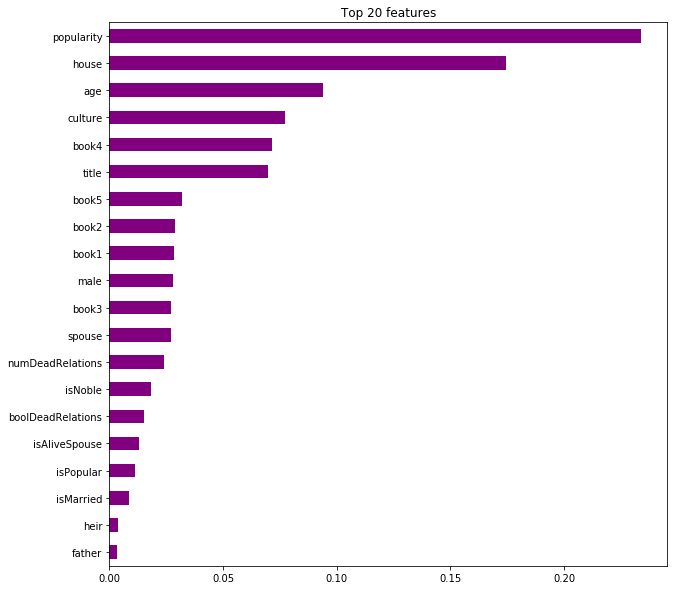

In [27]:
# plotting the features impotance 
rf = pipeline1.named_steps['randomforestclassifier']
importances = pd.Series(rfc.feature_importances_, 
                        df1.columns)
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='purple');                        

In [28]:
# Arranging permutation importance
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    rfc,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(x_fi,y_fi);

In [29]:
# Visualizing the weight of features
eli5.show_weights(
    permuter,
    top=12,
    feature_names=df1.columns.tolist()
)

Weight,Feature
0.1483 ± 0.0130,popularity
0.1342 ± 0.0119,book4
0.0746 ± 0.0073,house
0.0534 ± 0.0036,book2
0.0509 ± 0.0099,book5
0.0448 ± 0.0069,male
0.0414 ± 0.0055,culture
0.0388 ± 0.0049,book1
0.0330 ± 0.0049,book3
0.0312 ± 0.0033,age


In [30]:
# Arranging Gradient Boosting model
gb = make_pipeline(
    # ce.OneHotEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

# fitting the model
gb.fit(df1, y_fi)
y_pred = gb.predict(df1)
print('Gradient Boosting R^2', r2_score(y_fi, y_pred))

Gradient Boosting R^2 0.9439964486859064


In [31]:
features = ['title', 'male', 'culture', 'mother', 'father', 'heir', 'house',
       'spouse', 'book1', 'book2', 'book3', 'book4', 'book5', 'isAliveMother',
       'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble',
       'age', 'numDeadRelations', 'boolDeadRelations', 'isPopular',
       'popularity']

In [32]:
# Partial Dependence Plots with 1 feature
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
plt.rcParams['figure.dpi'] = 72

feature = 'male'

isolated=pdp_isolate(
    model=gb,
    dataset=df1,
    model_features=features,
    feature=feature
)

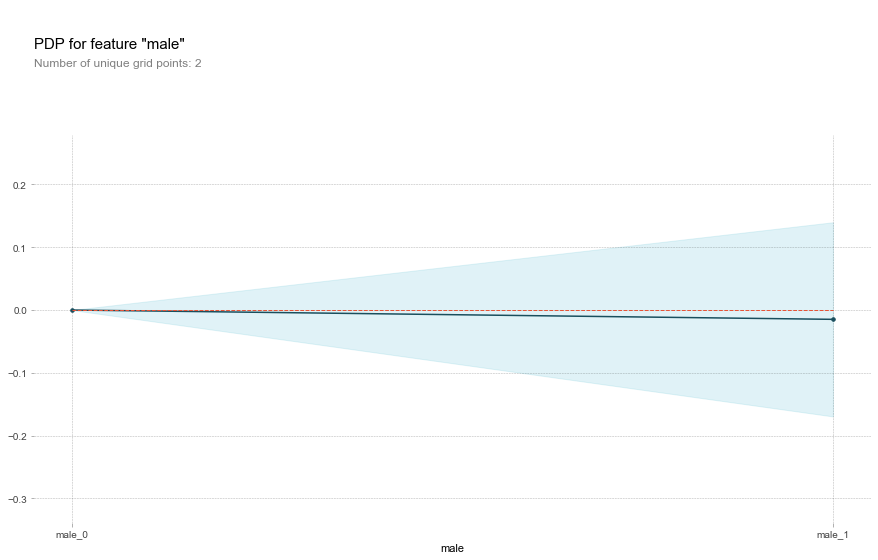

In [33]:
pdp_plot(isolated, feature_name=feature, plot_lines=False);

In [34]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

featu = ['popularity', 'age']

interaction = pdp_interact(
    model=gb,
    dataset=df1,
    model_features=features,
    features=featu
)

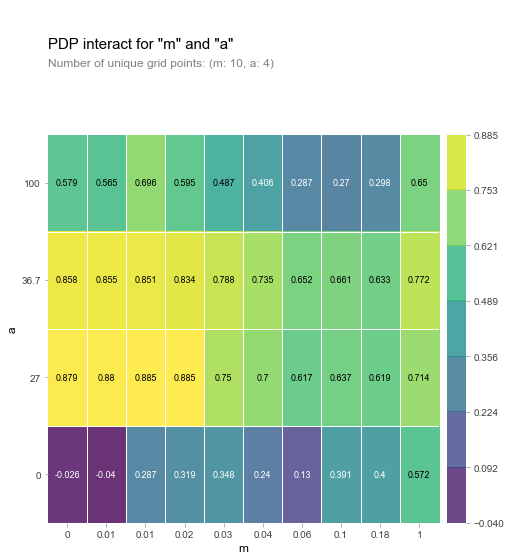

In [35]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=feature);

In [36]:
encoder = ce.OneHotEncoder()
X_encoded = encoder.fit_transform(df1)

In [37]:
model1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)
model1.fit(X_encoded, y_fi);

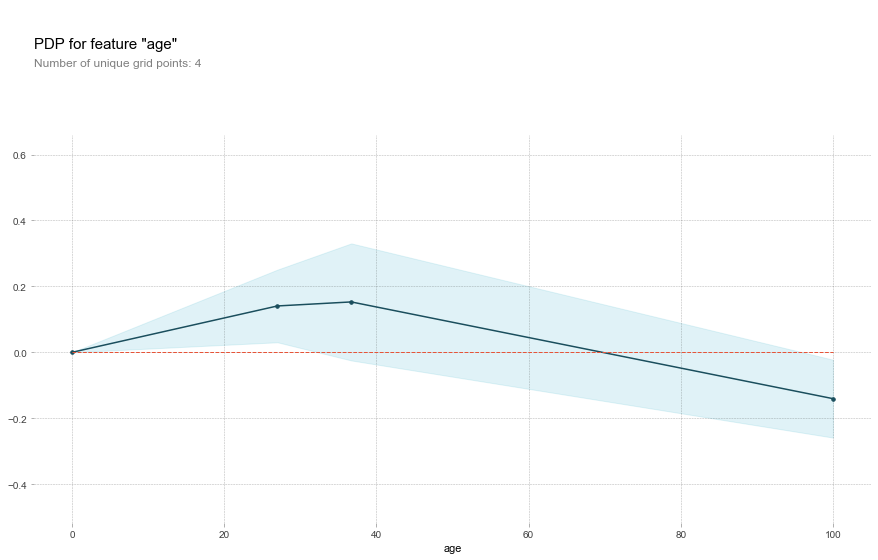

In [38]:
feature = 'age'
pdp_dist = pdp.pdp_isolate(model=model1, dataset=df1, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [55]:
# Shapley Visualization

from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=6, 
    random_state=42
)

search.fit(df1, y_fi);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    5.2s remaining:   12.4s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    6.3s remaining:    2.6s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    6.6s finished


In [56]:
model = search.best_estimator_

In [57]:
row = df1.iloc[[0]]
model.predict(row)

array([0.04678363])

In [58]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)